# A2: Bias in Data

In this notebook, we have done an exploratory analysis on Aggression and toxicity dataset from Wikipedia Talk on Figshare.
We will identify potential sources of bias in a corpus of human-annotated data, and describe some implications of those biases.

The corpus we will use is called the Wikipedia Talk corpus, and it consists of three datasets. Each dataset contains thousands of online discussion posts made by Wikipedia editors who were discussing how to write and edit Wikipedia articles. Crowdworkers labelled these posts for three kinds of hostile speech: “toxicity”, “aggression”, and “personal attacks”. Many posts in each dataset were labelled by multiple crowdworkers for each type of hostile speech, to improve accuracy.


Corpus - Wikipedia Talk corpus<br>
Source data - [Figshare](https://figshare.com/projects/Wikipedia_Talk/16731) <br>
Schema and descriptions -[here](https://meta.wikimedia.org/wiki/Research:Detox/Data_Release).<br>
Datasets - The dataset for three kinds of hostile speech: “toxicity”, “aggression”, and “personal attacks”. 

- **Aggression**: 100k labeled comments from English Wikipedia by approximately 10 annotators via Crowdflower on how aggressive the comment was perceived to be along with some demographic data for each crowd-worker.

- **Toxicity**: 160k labeled comments from English Wikipedia by approximately 10 annotators via Crowdflower on a spectrum of how toxic the comment is (perceived as likely to make people want to leave the discussion) to how healthy to conversation the contribution is.


**Goal ** - The goal of this assignment is to identify what, if any, sources of bias may exist in these datasets, and to develop testable hypotheses about how these biases might impact the behavior of machine learning models trained on the data, when those models are used for research purposes or to power data-driven applications. 


## Installing/ Importing the dataset

In [139]:
## Install the libraries (Depends on what )
##pip install nltk
##pip install wordcloud
##pip install matplotlib
##pip install urllib
##pip install os


In [120]:
# importing all libraries
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import requests
import numpy as np
from zipfile import ZipFile
from urllib.request import urlretrieve
import os
from wordcloud import WordCloud
import seaborn as sns
%matplotlib inline

In [89]:
#Dataset source
## Manually entering the link of the dataset from Figshare and storing that
## We are fetching data for 3 types of filters

TOXICITY_COMMENTS = 'https://ndownloader.figshare.com/files/7394542' 
TOXICITY_ANNOTATIONS = 'https://ndownloader.figshare.com/files/7394539'
TOXICITY_DEMOGRAPHICS = 'https://ndownloader.figshare.com/files/7640581'

ATTACK_COMMENTS = 'https://ndownloader.figshare.com/files/7554634' 
ATTACK_ANNOTATIONS = 'https://ndownloader.figshare.com/files/7554637'
ATTACK_DEMOGRAPHICS = 'https://ndownloader.figshare.com/files/7640752'

AGGRESSION_COMMENTS = 'https://ndownloader.figshare.com/files/7038038' 
AGGRESSION_ANNOTATIONS = 'https://ndownloader.figshare.com/files/7394506'
AGGRESSION_DEMOGRAPHICS = 'https://ndownloader.figshare.com/files/7640644'

In [90]:
## Using the webpage/ data url available, we now fetch the data/ download the data in data folder
urlretrieve(TOXICITY_COMMENTS, 'data/toxicity_comments.tsv')
urlretrieve(TOXICITY_ANNOTATIONS, 'data/toxicity_annotations.tsv')   
urlretrieve(TOXICITY_DEMOGRAPHICS, 'data/toxicity_demographics.tsv')   

urlretrieve(ATTACK_COMMENTS, 'data/attack_comments.tsv')
urlretrieve(ATTACK_ANNOTATIONS, 'data/attack_annotations.tsv')
urlretrieve(ATTACK_DEMOGRAPHICS, 'data/attack_demographics.tsv')

urlretrieve(AGGRESSION_COMMENTS, 'data/aggression_comments.tsv')
urlretrieve(AGGRESSION_ANNOTATIONS, 'data/aggression_annotations.tsv')   
urlretrieve(AGGRESSION_DEMOGRAPHICS, 'data/aggression_demographics.tsv')

('data/aggression_demographics.tsv',
 <http.client.HTTPMessage at 0x2cecb9f07c8>)

## Loading the fetched data and using it as a dataframe

In [91]:
toxicity_comments = pd.read_csv('data/toxicity_comments.tsv', sep='\t')
toxicity_annotations = pd.read_csv('data/toxicity_annotations.tsv', sep='\t')
toxicity_demographics = pd.read_csv('data/toxicity_demographics.tsv', sep='\t')

attack_comments = pd.read_csv('data/attack_comments.tsv', sep='\t')
attack_annotations = pd.read_csv('data/attack_annotations.tsv', sep='\t')
attack_demographics = pd.read_csv('data/attack_demographics.tsv', sep='\t')

aggression_comments = pd.read_csv('data/aggression_comments.tsv', sep='\t')
aggression_annotations = pd.read_csv('data/aggression_annotations.tsv', sep='\t')
aggression_demographics = pd.read_csv('data/aggression_demographics.tsv', sep='\t')

## Data Exploration

In [92]:
## Comments file for toxicity dataset
toxicity_comments.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


In [93]:
## Annotations file for toxicity dataset
toxicity_annotations.head()

,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0


In [94]:
## Worker Demographics file for toxicity dataset
toxicity_demographics.head()

,worker_id,gender,english_first_language,age_group,education
0,85,female,0,18-30,bachelors
1,1617,female,0,45-60,bachelors
2,1394,female,0,NaN,bachelors
3,311,male,0,30-45,bachelors
4,1980,male,0,45-60,masters


We observe that the data can be merged together using the 2 primary keys - 'worker_id' and 'rev_id'. 
First, we will use the worker_id field to join the dataframe for annotation nad demographics


In [95]:
## Merging the data 
toxicity_joined = toxicity_annotations.join(toxicity_demographics, on="worker_id", rsuffix="_demo")
attack_joined = attack_annotations.join(attack_demographics, on="worker_id", rsuffix="_demo")
aggression_joined = aggression_annotations.join(aggression_demographics, on="worker_id", rsuffix="_demo")


In [96]:
toxicity_joined.head()

,rev_id,worker_id,toxicity,toxicity_score,worker_id_demo,gender,english_first_language,age_group,education
0,2232.0,723,0,0.0,1789.0,male,1.0,30-45,bachelors
1,2232.0,4000,0,0.0,NaN,NaN,NaN,NaN,NaN
2,2232.0,3989,0,1.0,NaN,NaN,NaN,NaN,NaN
3,2232.0,3341,0,0.0,3974.0,male,0.0,18-30,hs
4,2232.0,1574,0,1.0,3863.0,female,0.0,18-30,professional


In [97]:
attack_joined.head()

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack,worker_id_demo,gender,english_first_language,age_group,education
0,37675,1362,0.0,0.0,0.0,0.0,0.0,3248.0,male,0.0,30-45,bachelors
1,37675,2408,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,37675,1493,0.0,0.0,0.0,0.0,0.0,2953.0,female,0.0,30-45,hs
3,37675,1439,0.0,0.0,0.0,0.0,0.0,49.0,male,0.0,18-30,professional
4,37675,170,0.0,0.0,0.0,0.0,0.0,1127.0,female,0.0,45-60,masters


In [98]:
aggression_joined.head()

,rev_id,worker_id,aggression,aggression_score,worker_id_demo,gender,english_first_language,age_group,education
0,37675,1362,1.0,-1.0,3248.0,male,0.0,30-45,bachelors
1,37675,2408,0.0,1.0,NaN,NaN,NaN,NaN,NaN
2,37675,1493,0.0,0.0,2953.0,female,0.0,30-45,hs
3,37675,1439,0.0,0.0,49.0,male,0.0,18-30,professional
4,37675,170,0.0,0.0,1127.0,female,0.0,45-60,masters


## We will explore this dataset and perform  analysis to check for bias


## Analysis : 	Analyze the demographic information about the Crowdflower workers that is available in the dataset

#### Research Questions
Looking at the demographic profiles of the crowdworkers who are labelling the comments as aggressive or toxic, do we observe a fair representation or some bias in the proportion of any particular -
1. Gender?
2. Age?
3. Education?
Is it significantly differnet or can it impact the results? 


#### Exploratory Analysis

1. The distribution of workers by gender who are labelling the comments datasets 
2. The distribution of workers by age who are labelling the comments datasets 
3. The distribution of workers by education who are labelling the comments datasets 


#### Dataset for this analysis
I would be doing this analysis on all the three datasets to provide a deeper understanding of bias.

In [110]:
## Created a function to get pie chart for a field for all dataset
import matplotlib.pyplot as plt

def bias_pie(attribute):
     
    fig = plt.figure()
    typ = 'Aggressive'
    ttl = attribute + ' distribution for ' + typ +' Comments'

    ax1 = fig.add_axes([0, 0, .5, .5], aspect=0.5)
    ax1.pie(aggression_joined[attribute].value_counts(), labels = aggression_joined[attribute].value_counts().index.tolist(), autopct='%1.2f%%')
    
    ax1.set_title(ttl)
    
    plt.figure(1)
    typ = 'Toxic'
    ttl = attribute + ' distribution for ' + typ +' Comments'

    ax2 = fig.add_axes([.6, .0, .5, .5], aspect=1)
    ax2.pie(toxicity_joined[attribute].value_counts(), labels = toxicity_joined[attribute].value_counts().index.tolist(), autopct='%1.2f%%')
    ax2.set_title(ttl)
    
    plt.figure()

    typ = 'Attack'
    ttl = attribute + ' distribution for ' + typ +' Comments'
    ax3 = fig.add_axes([1.2, 0, .5, .5], aspect=1)
    #ax3.pie(fracs, labels=labels, radius = 1.5)
    ax3.pie(attack_joined[attribute].value_counts(), labels = attack_joined[attribute].value_counts().index.tolist(), autopct='%1.2f%%')
    ax3.set_title(ttl)
    


    plt.show()
    plt.savefig('output/' + attribute + '_bias_piechart.png')



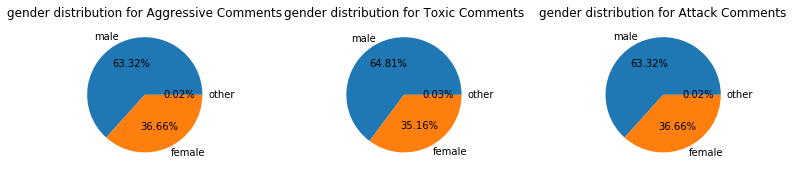

<Figure size 432x288 with 0 Axes>

In [112]:
bias_pie('gender')


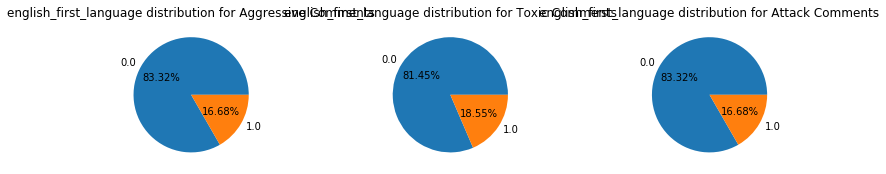

<Figure size 432x288 with 0 Axes>

In [113]:
bias_pie('english_first_language')


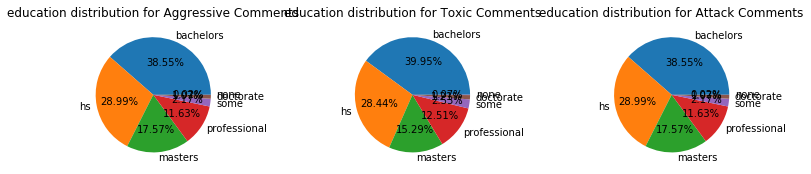

<Figure size 432x288 with 0 Axes>

In [114]:
bias_pie('education')


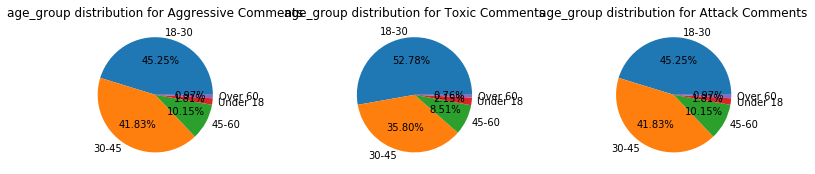

<Figure size 432x288 with 0 Axes>

In [115]:
bias_pie('age_group')


#### What did I find?

**Gender**
We observe from the above plot that there is a gender imbalance in the crowdworkers. We see that in all the 3 sets- there is a bias towards the male population i.e. though the general population has 50% share of males and females, we observe that in our data males represents around 65% of the population whereas females are only around 35%. Thus, the females are underrepresented and that can lead to potential biases in interpretation of comments. <br>
Also, we dont have any information regarding the 'Other' category and won't be able to consider them

**English as 1st language**
We observe from the above plot that there is a proportion of segment(around 15%) in each set where english is the first language. This could create a potential bias on the dataset as the general population around the world has less than 10% people with english as their first language. We see that in all the 3 sets- there is a bias towards the population where english is  the first language. 

**Education**
As we can see from the plots above, there is a significant difference between how workers from different education background have labelled this dataset. The group described as none has very different proportions compared to other groups. Looking across all the 3 segments, we observe a higher proportion of 18-30 age group in toxic comments(53%) compared to the other 2 segments (45%). We can see that this could lead to a slightly different trend in toxic comments compared to others.
<br>
This bias can be explained due to the different experiences and differnt maturity levels that come with different education. Education level can make a person more tolerable or intolerable towards particular sentiments. <br>

**Age**
As we can see from the plots above, there is a difference between how workers from different age groups have labelled this dataset. For example, age group over 60 is much more likely to report a comment as toxic compared ot other groups. Similarly, age group under 18 is much more likely to report a comment as aggressive compared to other groups
<br>
This bias can stem due to the different experiences and differnt maturity levels at differnt age. Someone under 18 would percieve the world very differently from someone above 60. <br>




## Analysis : 	Explore relationships between worker demographics and labeling behavior

#### Research Questions

In the above analysis, we saw if there is any bias in the dataset compared to the general population. Now, we want to look into the relationships in the dataset. Are the young people more likely to be commenting more toxic and attack information and old people more polite or the other way around? 



#### Exploratory Analysis

1. The distribution of workers by age who are labeling the comments datasets 
2. The distribution of workers by proportion of toxic/aggressive labels 


#### Dataset for this analysis
I would be doing this analysis on all the three datasets to provide a deeper understanding of bias.

In [121]:
## Created a function to get histogram chart for a field for all dataset 
def bias_hist(attribute):
    df1 = toxicity_joined[[attribute,'toxicity']].groupby(attribute).mean()
    df2 = attack_joined[[attribute,'attack']].groupby(attribute).mean()
    df3 = aggression_joined[[attribute,'aggression']].groupby(attribute).mean()
    df = pd.concat([df1, df2, df3], axis=1)

    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    df.T.plot.bar(ax = axs[0])
    df.plot.bar(ax = axs[1])

    if not os.path.exists('output'):
        os.makedirs('output')
    
    plt.savefig('output/' + attribute + '_bias_hist.png')

    

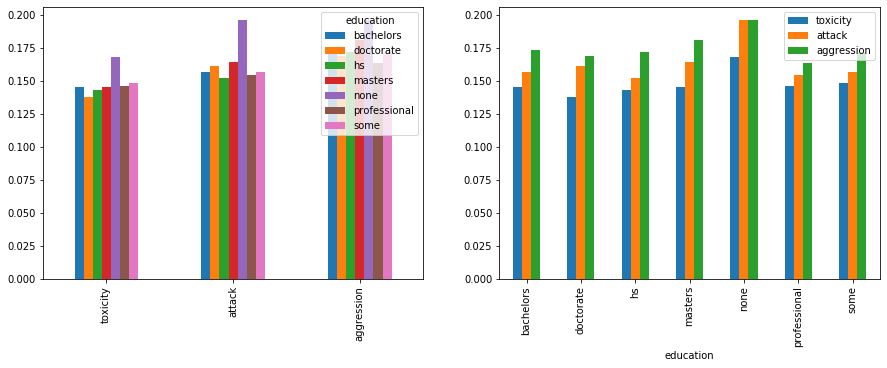

In [122]:
bias_hist('education')

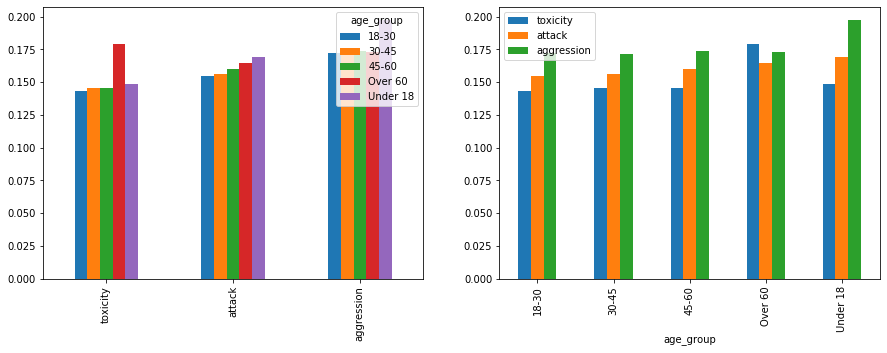

In [124]:
bias_hist('age_group')

Type,Aggression Data Annotators,Toxicity Data Annotators
age_group,,
0-18,18926,29518
18-30,472780,725606
30-45,437009,492067
45-60,106047,117030
Over 60,10087,10449


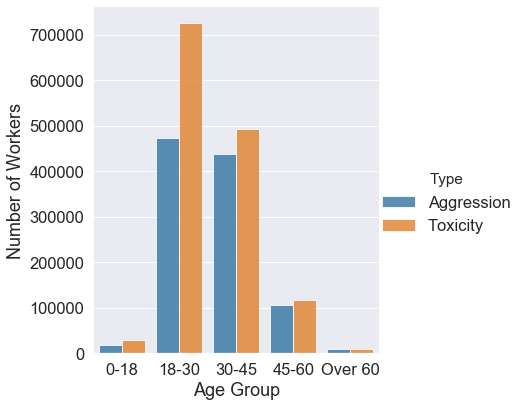

In [126]:
# Calculate number of workers by age group

agg_age_workers = aggression_joined.groupby(['age_group']).worker_id.agg('count').to_frame('workers_count').reset_index()
agg_age_workers['Type'] = "Aggression"

tox_age_workers = toxicity_joined.groupby(['age_group']).worker_id.agg('count').to_frame('workers_count').reset_index()
tox_age_workers['Type'] = "Toxicity"

age_workers = agg_age_workers.append(tox_age_workers)
age_workers = age_workers.replace(['Under 18'], '0-18')
age_workers = age_workers.sort_values(['age_group'])

# Tabular Output

age_workers_table = pd.pivot_table(age_workers, values='workers_count', index=['age_group'],
                    columns=['Type'], aggfunc=np.sum)
age_workers_table = age_workers_table.rename(columns={ "Aggression": "Aggression Data Annotators", 
                                                        "Toxicity" : "Toxicity Data Annotators" })
display(age_workers_table)

# Bar Chart Output

sns.set_style('ticks')
sns.set_style("whitegrid") #gridlines
sns.set(font_scale=1.5)  

g = sns.catplot(
    data=age_workers, kind="bar",
    x="age_group", y="workers_count", hue="Type",
    ci="sd", palette="tab10", alpha=.8, height=6
)
g.despine(left=True)
g.set_axis_labels("Age Group", "Number of Workers")

# Save Output

g.savefig("output/workersbyage.png") 


We observe that the data is skewed towards the age group 18-45, which does not represents the general population. Thus, we move towards looking at the percentage of comments that annotators across different age groups labelled as aggressive or toxic.

We will calculate the % comments labelled as aggressive or toxic by workers across different age groups. 

Type,% Aggressive Comments,% Toxic Comments
age_group_,,
0-18,19.8,14.8
18-30,17.2,14.3
30-45,17.1,14.6
45-60,17.4,14.5
Over 60,17.3,17.9


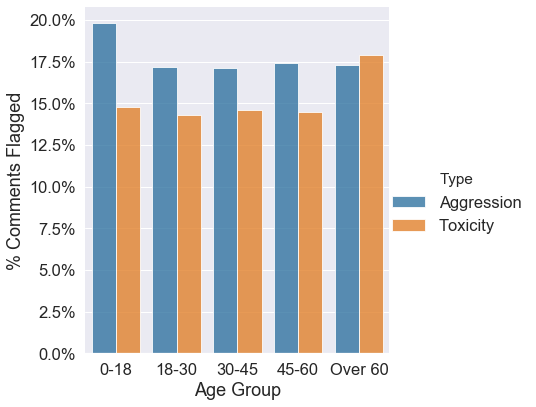

In [137]:
# % Comments of flagged for aggession and toxicity by age_group
from  matplotlib.ticker import PercentFormatter
agg_age_comments = aggression_joined.groupby('age_group', as_index=False).agg(
    {'aggression':['sum', 'count']})
agg_age_comments.columns = ["_".join(x) for x in agg_age_comments.columns.ravel()]
agg_age_comments['Percentage'] = round(agg_age_comments['aggression_sum']/agg_age_comments['aggression_count'], 3) 
agg_age_comments['Type'] = "Aggression"
#display(agg_age_comments) #QC

tox_age_comments = toxicity_joined.groupby('age_group', as_index=False).agg(
    {'toxicity':['sum', 'count']})
tox_age_comments.columns = ["_".join(x) for x in tox_age_comments.columns.ravel()]
tox_age_comments['Percentage'] = round(tox_age_comments['toxicity_sum']/tox_age_comments['toxicity_count'], 3) 
tox_age_comments['Type'] = "Toxicity"
#display(tox_age_comments) #QC

# Merge the above 2 tables for plotting
comments_flagged_age = agg_age_comments.append(tox_age_comments)
comments_flagged_age = comments_flagged_age.replace(['Under 18'], '0-18')
comments_flagged_age = comments_flagged_age.sort_values(['age_group_'])
#display(comments_flagged_age) # view table

# Tabular Output

age_comments_table = pd.pivot_table(comments_flagged_age, values='Percentage', index=['age_group_'],
                    columns=['Type'], aggfunc=np.sum)
age_comments_table['Aggression'] = (100*age_comments_table['Aggression'])
age_comments_table['Toxicity'] = 100*age_comments_table['Toxicity']
age_comments_table = age_comments_table.rename(columns={ "Aggression": "% Aggressive Comments", 
                                                        "Toxicity" : "% Toxic Comments" })
display(age_comments_table)

# Bar Chart Output

sns.set_style('ticks')
sns.set_style("whitegrid") #gridlines
sns.set(font_scale=1.5)  

g = sns.catplot(
    data=comments_flagged_age, kind="bar",
    x="age_group_", y="Percentage", hue="Type",
    ci="sd", palette="tab10", alpha=.8, height=6
)
g.despine(left=True)
g.set_axis_labels("Age Group", "% Comments Flagged")

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    
# Save Output

g.savefig("output/PercentCommentsbyAge.png") 


Overall, we see a trend of higher aggressive comments than toxic comments. Though there is not a significant change.
Looking at the plot, we see a sudden increase in toxic comments for the age group 'over 60' and increase in aggressive comments for '0-18' age groups. This may be an indication that older age groups might be more sensitive to toxic language compared to younger annotators which may introduce bias in the labelling process.

The sudden change in 'Over 60' and '0-18' age group seems to be higher or differnt, but when we look at the count- they dont contribute much to the overall numbers. Thus, we do not observe any potential bias here.

## Step 2: Implications for research and product development

**What are some kinds of hostile speech that would be difficult to accurately detect using the approach used to train the Perspective API models?**

Sol. Since Perspective API models have been trained on an English corpus labeled by English crowdworkers, there are lot of other speeches where this dataset may not work. For example-

- Hostile speech written in some other language
- Change in demographic for all the countries could not be captured in the dataset when we also have the criteria 'knowledge of english language'
- Data with Sarcastic comments 



**Which, if any, of these demo applications would you expect the Perspective API—or any model trained on the Wikipedia Talk corpus—to perform well in? Why?**

According to me, the performance of a model is highly dependent on the problem statement. Therefore, this dataset would perform good in applications related to identifying the toxicity or aggression in the speech. Thus, it should work well for the comment filter based on level of toxicity, since the model based on this dataset can do a great job at filtering our toxic or aggressive comments on the internet.


**What are some other contexts or applications where you would expect the Perspective API to perform particularly well, or particularly poorly? Why?**

Perspective API has been trained on comments from English Wikipedia talk pages. Comments on Wikipedia are free text but is slightly biased by the people who use this i.e. education or age bias might occur. Thus, the kind/type of hostility that is seen on ths comments from English Wikipedia talk pages is very specific and the trained model would be well aversed with that only. If this model is used on online portals or sites like Twitter, facebook, etc with a huge population , then Perspective API will tend to perform poorly. On the other hand, it will perform really well on other educational platforms or wikipedia.
